In [5]:
import keras
import datetime
from keras.models import Model, load_model
import os
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.layers import Input, Reshape, UpSampling2D, Conv2D, Conv1D, Dense, Dropout, BatchNormalization, Flatten, Conv2DTranspose
import numpy as np
from skimage import io, color
from keras.preprocessing import image
import numpy as np
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.layers import Conv2D
from skimage import io, color, transform
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import os
image_size = 256

now = datetime.datetime.now()

image_path = "drive/My Drive/app/input/256/Test"

def read_image(img_id, dir):
    try:
        img = load_img(dir + "/" + img_id, target_size=(256,256))
        img = img_to_array(img)
        return img
    except:
        return None

def convLayer(input, filters, kernel_size,  stride=1):
    return Conv2D(filters, kernel_size, padding="same", activation="relu", strides=stride)(input)

input_shape = (image_size, image_size, 1)

model_input = Input(shape = input_shape)

# conv1
model_output = convLayer(model_input, 64, (3, 3))
model_output = convLayer(model_output, 64, (3, 3), stride=2)
model_output = BatchNormalization()(model_output)
# conv2
# model_output = convLayer(model_output, 128, (3, 3))
model_output = convLayer(model_output, 128, (3, 3), stride=2)
model_output = BatchNormalization()(model_output)
# conv3
# model_output = convLayer(model_output, 256, (3, 3))
# model_output = convLayer(model_output, 256, (3, 3))
model_output = convLayer(model_output, 256, (3, 3), stride=2)
model_output = BatchNormalization()(model_output)
# conv4
# model_output = convLayer(model_output, 512, (3, 3))
model_output = convLayer(model_output, 512, (3, 3))
model_output = convLayer(model_output, 512, (3, 3))
model_output = BatchNormalization()(model_output)
# conv5
# model_output = convLayer(model_output, 512, (3, 3), dilation=2)
# model_output = convLayer(model_output, 512, (3, 3), dilation=2)
# model_output = convLayer(model_output, 512, (3, 3), dilation=2)
# model_output = BatchNormalization()(model_output)
# conv6
# model_output = convLayer(model_output, 512, (3, 3), dilation=2)
# model_output = convLayer(model_output, 512, (3, 3), dilation=2)
# model_output = convLayer(model_output, 512, (3, 3), dilation=2)
# model_output = BatchNormalization()(model_output)
# conv7
# model_output = convLayer(model_output, 256, (3, 3))
# model_output = convLayer(model_output, 256, (3, 3))
# model_output = convLayer(model_output, 256, (3, 3))
# model_output = BatchNormalization()(model_output)
# conv8
model_output = UpSampling2D((2, 2))(model_output)
model_output = convLayer(model_output, 256, (3, 3))
model_output = UpSampling2D((2, 2))(model_output)
model_output = convLayer(model_output, 256, (3, 3))
model_output = UpSampling2D((2, 2))(model_output)
model_output = convLayer(model_output, 256, (3, 3))

# unary prediction
reshaped_output = Reshape((image_size*image_size, 256))(model_output)
model_output = Conv1D(313, (1), padding="same", activation="softmax")(reshaped_output)
model = Model(inputs=model_input, outputs=model_output)

model.load_weights("D:\Libraries\Documents\Image_Colorization\output\model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [11]:
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
Xtest = []
for image in files:
    img = read_image(image, directory)
    if not img is None:
        img = np.array(img, dtype=float)
        Xtest.append(img)
Xtest

[array([[[119., 182., 236.],
         [120., 183., 237.],
         [123., 186., 240.],
         ...,
         [223., 252., 250.],
         [221., 251., 249.],
         [221., 251., 249.]],
 
        [[119., 182., 236.],
         [121., 184., 238.],
         [124., 187., 241.],
         ...,
         [223., 252., 250.],
         [221., 251., 249.],
         [221., 251., 249.]],
 
        [[121., 184., 238.],
         [122., 185., 239.],
         [125., 188., 241.],
         ...,
         [223., 253., 251.],
         [222., 252., 250.],
         [222., 252., 250.]],
 
        ...,
 
        [[ 65.,  49.,  34.],
         [ 75.,  58.,  42.],
         [ 81.,  62.,  45.],
         ...,
         [ 13.,  19.,   7.],
         [ 13.,  16.,   9.],
         [ 12.,  14.,   9.]],
 
        [[ 60.,  46.,  35.],
         [ 67.,  51.,  38.],
         [ 72.,  54.,  40.],
         ...,
         [ 22.,  25.,  14.],
         [ 17.,  18.,  10.],
         [ 12.,  13.,   7.]],
 
        [[ 40.,  26.,  17.],
 

D:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


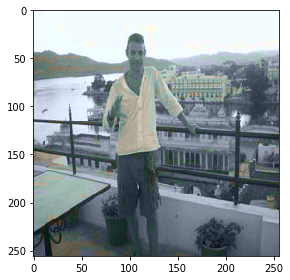

In [45]:
def bucketize_gaussian(imagesAB, buckets, batch_size):
    #calculate the distances from each pixel to each bucket
    distances = np.zeros((batch_size*image_size*image_size, buckets.shape[0]))
    distances = cdist(imagesAB.reshape(batch_size*image_size*image_size, 2), buckets)
    #find five shortest ones
    shortest_distances_indices = np.argpartition(distances, 5)
    five_shortest_distances_indices = shortest_distances_indices[:, :4]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
    #zero the others
    vertical_indices = np.arange(batch_size*image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
    #pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    return distances.reshape(batch_size, image_size, image_size, 313)

Lab = color.rgb2lab(Xtest)
inputs_true_ab = bucketize_gaussian(Lab[:, :, :, 1:], buckets, 2)
input_concat = np.zeros((256, 256, 3))
input_concat[:, :, 0] = Lab[1, :, :, 0]
input_concat[:, :, 1:] = buckets[np.argmax(inputs_true_ab[1, :, :, :], axis=2)]
io.imshow(color.lab2rgb(input_concat))
plt.show()

In [17]:
np.argmax(inputs_true_ab[1, :, :, :], axis=2).shape

(256, 256)

In [ ]:
directory = "D:/Libraries/Documents/Image_Colorization/data/Train_1/Train"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
Xtest = []
for image in files:
    img = read_image(image, directory)
    if not img is None:
        img = np.array(img, dtype=float)
        Xtest.append(img)

buckets = np.load("D:/Libraries/Documents/Image_Colorization/utilities/pts_in_hull.npy")
Xtest = np.array(Xtest, dtype=float)
Xtest = 1.0/255*Xtest
inputs = color.rgb2lab(Xtest)[:, :, :, 0]
inputs_2 = inputs - 50
inputs_2 = inputs_2 / 100
inputs_2 = inputs_2.reshape(inputs_2.shape+(1,))
inputs = inputs.reshape(inputs.shape+(1,))

# Test model
output = model.predict(inputs_2)
output = output.reshape(2, image_size, image_size, 313)

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = inputs[i][:,:,0]
    cur[:,:,1:] = buckets[np.argmax(output[i], axis=2)]
    io.imshow(color.lab2rgb(cur))
    plt.show()

In [43]:
np.argmax(output[0, :, :, :], axis=2)

array([[121, 121, 121, ..., 139, 139, 139],
       [121, 121, 121, ..., 139, 139, 139],
       [121, 121, 121, ..., 139, 139, 119],
       ...,
       [119, 119, 119, ..., 119, 119, 119],
       [119, 119, 119, ..., 119, 119, 119],
       [119, 119, 119, ..., 119, 119, 119]], dtype=int64)

In [0]:
print(np.max(output))
print(np.min(output))
print(np.mean(output[:, :, :, 0]))
print(np.mean(output[:, :, :, 1]))
output[:, :, :, 0] -= 48.4
output[:, :, :, 1] -= 27.7

35.965965
-33.315483
0.63114285
3.7851474


In [0]:
print(np.max(inputs))
print(np.min(inputs))
print(np.mean(inputs))
inputs[1][:, :, 0]

100.0
0.0
50.4688864524391


array([[86.09868201, 81.80499941, 78.55384399, ..., 77.10412264,
        78.08432634, 76.40181827],
       [86.45444597, 82.88273822, 79.2786915 , ..., 76.41982919,
        77.31402892, 75.69660566],
       [86.77665039, 84.12886603, 81.08486713, ..., 78.39040101,
        75.6133076 , 75.08445546],
       ...,
       [74.36572779, 74.73267844, 79.47012775, ..., 71.29188265,
        73.87433937, 73.87433937],
       [77.65513727, 77.65513727, 77.65513727, ..., 70.92141284,
        70.55054882, 71.29188265],
       [77.65513727, 77.29108791, 75.0992588 , ..., 71.29188265,
        67.9432469 , 68.31694278]])

In [0]:
print(np.mean((Xtest_lab[:, :, :, 2])))
print(Xtest_lab.shape)

1.702994587076077
(200, 256, 256, 3)
